In [3]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn

In [4]:
Nx = 200
cfl = 0.2 # CFL Number
tmax = 1 # time 0 ~ 1
viscosity_coeff = (0.01/math.pi)
x = np.linspace(-1, 1, 200)

#t = 0 ,I.C
u = -1 * np.sin(math.pi * x)
dx = abs(x[1] - x[0])

dt = cfl * dx / np.max(np.abs(u))

nt = int(tmax / dt) + 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )


498
0.0020101128725153656
1.001036210512652 1


In [5]:
#np.roll(u, 1) # rollは1step前の情報を組み込む

In [6]:
#u

In [7]:
def minmod(a, b):
    return 0.5*(np.sign(a)+np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [8]:
def f(u):
    y = 0.5 * u**2
    yp =  u
    return y, yp

In [9]:
def RHS(u, dx, viscosity_coeff):

    #diffusion term
     diffusion_term = viscosity_coeff * (np.roll(u, 1)- 2*u + np.roll(u, -1))/ dx**2

     ux = minmod(( u - np.roll(u, 1))/dx, (np.roll(u,-1) - u)/dx )
     uL = np.roll(u - 0.5 * dx * ux,1)
     uR = u - 0.5 * dx * ux
     fL,fpL = f(uL)
     fR,fpR = f(uR)
     a = np.maximum(np.abs(fpL), np.abs(fpR))

     H =  0.5 *( fL + fR - a *(uR - uL) )

     conv_term = -(np.roll(H, -1)- H)/dx

     y = conv_term + diffusion_term
     return y


In [10]:
for i in range(1, nt):
    u1 = u + dt * RHS(u, dx, viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx, viscosity_coeff))
    uf[i, :] = u

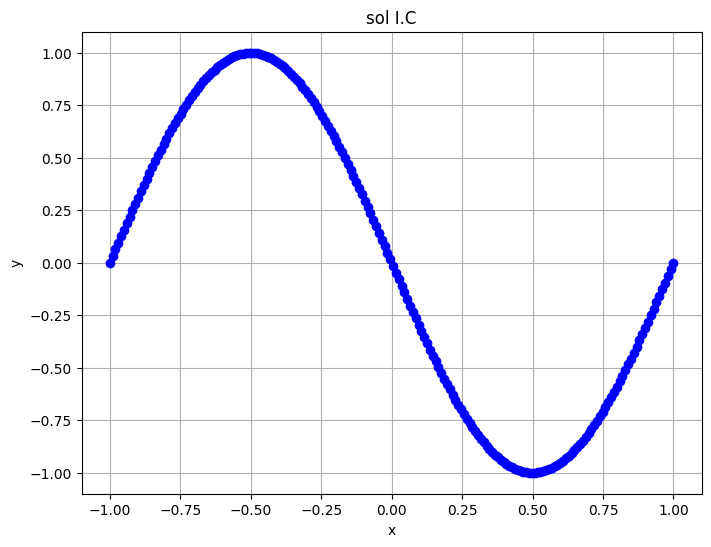

In [11]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

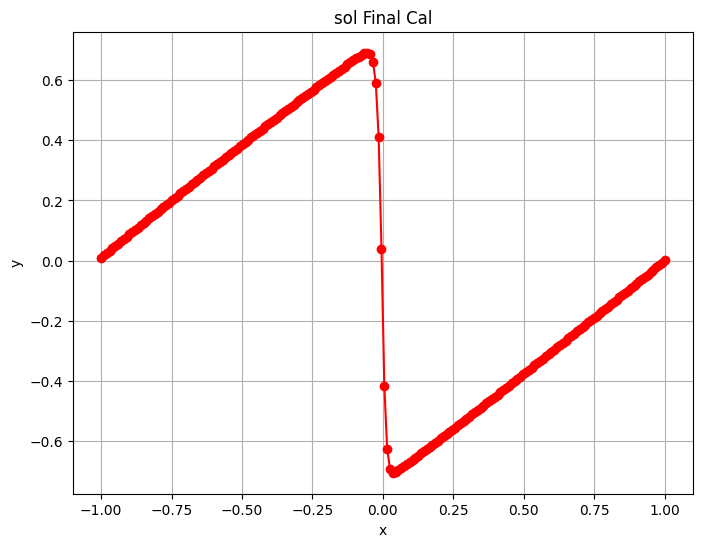

In [12]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

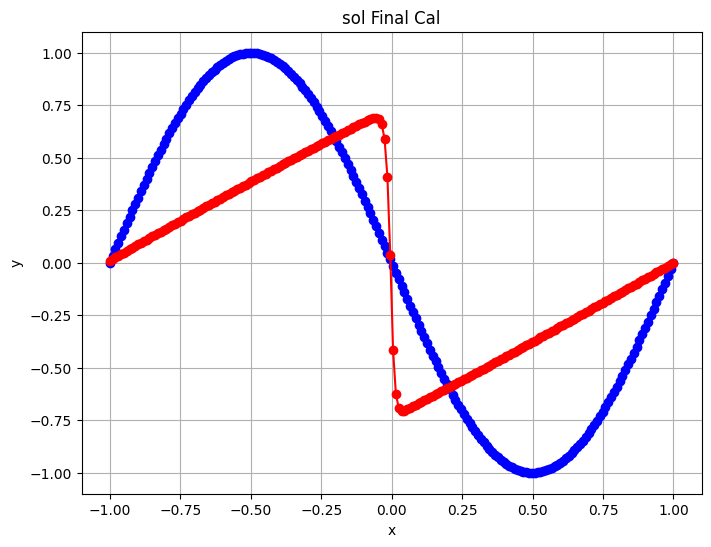

In [13]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [14]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi = 3000)
sns.heatmap(uf.T, cmap='jet')

<Axes: >

# PINN

In [15]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
       out = self.net(x)
       return out

def init_weights_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [16]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)
        self.model.apply(init_weights_xavier)  # ← Xavier初期化を適用！

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2, -1).T

        # train data
        # BC and IC define
        bc1 = torch.stack(torch.meshgrid(torch.tensor([x[0]]), t, indexing='ij')).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(torch.tensor([x[-1]]), t, indexing='ij')).reshape(2, -1).T
        ic  = torch.stack(torch.meshgrid(x, torch.tensor([t[0]]), indexing='ij')).reshape(2, -1).T
        #bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2, -1).T # first element value is zero
        #bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2, -1).T # final element value is zero
        #ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(torch.pi * ic[:, 0])

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam = torch.optim.Adam(self.model.parameters())

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno(L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval = 50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
           )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True
        )[0]

        du_dxx = du_dXX[:,0]

        # The key point is to take the MSE between the left and right sides of the PDE.
        # du/dt + u*du/dx = viscocity * d2u/dx2
        loss_pde = self.criterion( du_dt + u.squeeze()*du_dx, (0.01/torch.pi) * du_dxx )
        loss = loss_data + loss_pde
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter, loss.item())

        self.iter += 1
        return loss

    def train(self):
      self.model.train()
      for i in range(1000):
          self.adam.step(self.loss_func)
      self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [17]:
# training
net = Net()
net.train()


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.10207591950893402
200 0.0839453861117363
300 0.07114630937576294
400 0.05911513417959213
500 0.0360565148293972
600 0.023311704397201538
700 0.018986200913786888
800 0.015503134578466415
900 0.012710544280707836
1000 0.012229079380631447
1100 0.005989367142319679
1200 0.0029365704394876957
1300 0.0017775280866771936
1400 0.0010352690005674958
1500 0.0007353972760029137
1600 0.0005003748228773475
1700 0.00037892235559411347
1800 0.0002924799337051809
1900 0.00023957125085871667
2000 0.0002029287861660123
2100 0.00017341671627946198
2200 0.0008860270027071238
2300 0.00012882857117801905
2400 0.00011316748714307323
2500 9.187563409795985e-05
2600 7.949395512696356e-05
2700 7.088705024216324e-05
2800 6.313972698990256e-05
2900 5.674663407262415e-05
3000 5.0806356739485636e-05
3100 4.464289668248966e-05
3200 3.98103438783437e-05
3300 3.5322344047017395e-05
3400 3.2764564821263775e-05
3500 3.1139294151216745e-05
3600 6.754395872121677e-05
3700 2.818568827933632e-05
3800 2.6543468266027

In [19]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred,cmap='jet')
plt.show()

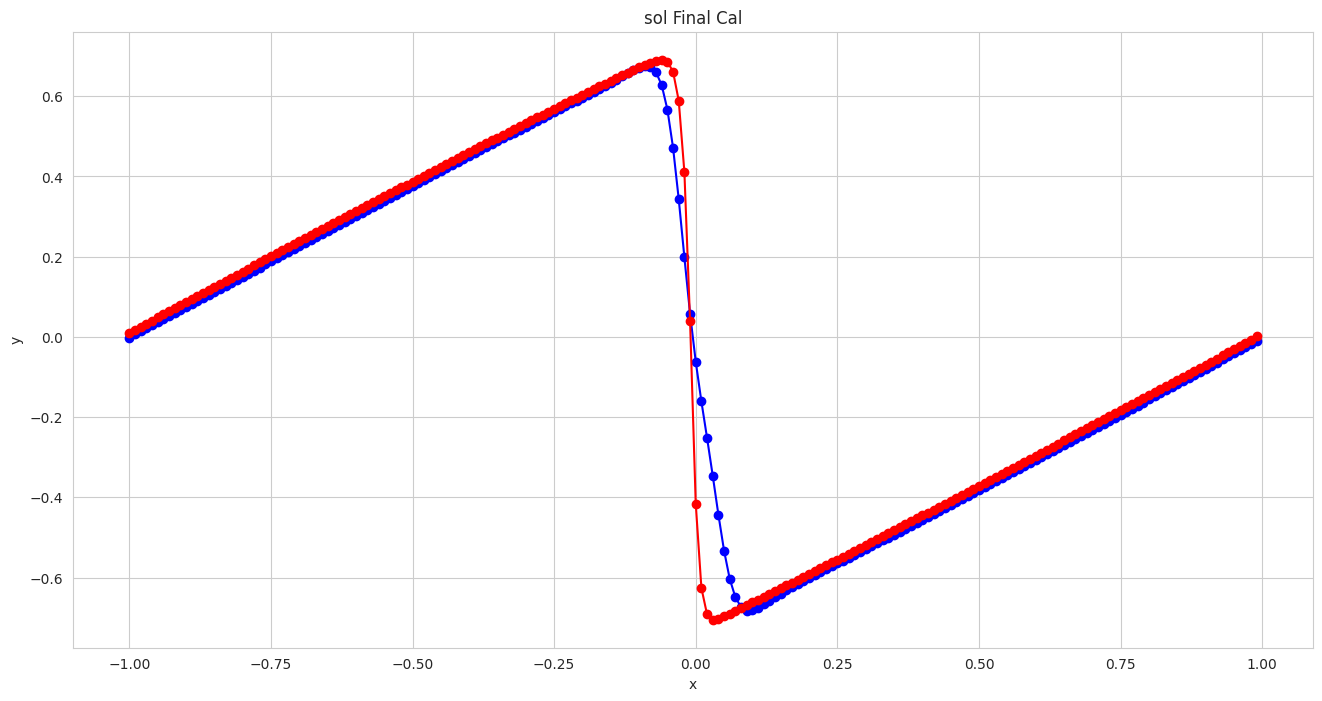

In [22]:
plt.figure(figsize=(16,8))
plt.plot(x, y_pred[:, -1], '-o', color = 'b') #PINN
plt.plot(x, uf[-1], '-o', color = 'r') # TVD
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()